# Hypothesis Testing with Insurance Data (Core)
Nena Esaw

1. State your Null Hypothesis and Alternative Hypothesis
2. Select the correct test according to the data type and number of samples
3. Test the assumptions of your selected test.
4. Execute the selected test, or the alternative test (if you do not meet the assumptions)
5. Interpret your p-value and reject or fail to reject your null hypothesis 
6. Show a supporting visualization that helps display the result

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['insurance - insurance.csv']

### Load Data 

In [6]:
data = 'Data/insurance - insurance.csv'
df = pd.read_csv(data)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Do smokers have higher insurance charges than non-smokers?

#### Use t-test 

 Hypothesis

* Null hypothesis - people that smoke pay more for insurance 
* Alternate - there is no difference in charges for people that smoke and don't smoke 

### T-test 

In [7]:
#see how many smokers vs non-smokers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

<Axes: xlabel='smoker', ylabel='charges'>

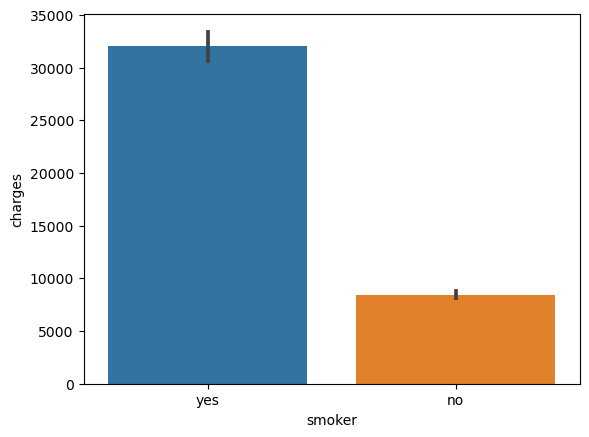

In [18]:
sns.barplot(data=df, x='smoker', y='charges')

In [8]:
#filtering out smokers and non smokers
smoker = df.loc[df['smoker']== 'yes'].copy()
non_smoker = df.loc[df['smoker']== 'no'].copy()


In [9]:
#define feature of interest 
smoker_charges = smoker['charges']
non_smoker_charges = non_smoker['charges']

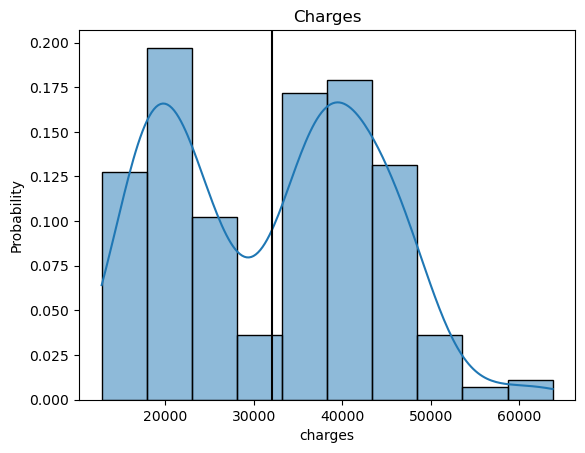

In [33]:
ax = sns.histplot(x=smoker['charges'],stat='probability',kde=True)
ax.axvline(smoker['charges'].mean(), color='k')
ax.set_title("Charges");



* The graph is showing that we have some outliers on the non_smoker side. 

#### Testing for Outliers 

In [10]:
#testing for outliers for smokers 
zscores_f = stats.zscore(smoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)



0

In [11]:
zscores_f = stats.zscore(non_smoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)



24

In [12]:
# remove outlier for non smoker group 
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]


#### Normality Testing 

In [13]:
result = stats.normaltest(smoker_charges)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05



NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)


True

In [15]:
result = stats.normaltest(non_smoker_charges)
print(result)
# is the p-value less than 0.05?
result.pvalue < .05


NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)


True

* The data set is large enough to safely ignore the normaility assumption. 

#### Equal Variance 

In [16]:
#testing for equal variance 
result = stats.levene(smoker_charges, non_smoker_charges)
result



LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

* The equal variance test failed so we will perform an independent t-test. 

In [17]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var = False)
result



Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

* The p-value < alpha(0.05), so we reject the null hypothesis and accept there is a significiant difference between the insurance charges of smokers and non smokers. 

### Are men more likely to smoke than women?

Hypothesis 
* null hypothesis: smokers are determined by sex
* alternate hypothesis: the sex of a person does not determine if they will smoke or not

### Chi-Square 

In [37]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table



smoker,no,yes
sex,,
female,547,115
male,517,159


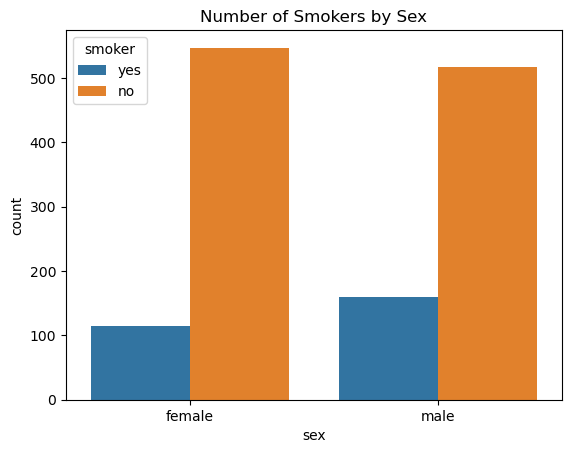

In [36]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");


In [38]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results



In [39]:
# What was our p-value?
print(p)
p<.05



0.006548143503580696


True

* We reject the null hypothesis. The p-value < alpha(0.05), so we reject the null hypothesis and accept there is a significiant difference. 

### Do different regions have different charges, on average?

In [20]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

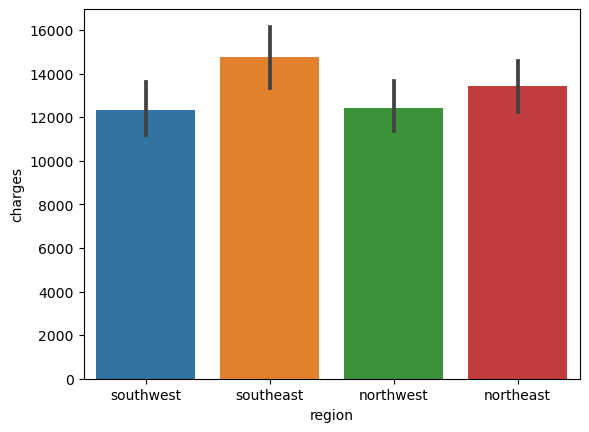

In [21]:
sns.barplot(data=df, x='region',y='charges');

Hypothesis 

* Null hypothesis: Do different regions reult in a difference in insurance charges 
* Alternate hypothesis: There is no difference in charges based on region. 

### ANOVA Testing 

In [22]:
## Create groups dictionary
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

#### Testing for normalities 

In [24]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [25]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


* Groups are large enough to safely ignore the normaility test.

#### Testing assumption of equal variance 

In [26]:
# with the * operator 
stats.levene(*groups.values())


LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

* Failed equal variance test will neeed to do the kruskal wallis test 

In [27]:
# perform the kruskal wallis test 
# note again the use of the * operator for convenience
result = stats.kruskal( *groups.values())
result



KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

* We passed the kurskal wallis test and there is not a significant difference in charges depending on region. 

#### Tukey's Pairwise comparisons test 

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']



In [28]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()



group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


* We can see that there is significant difference between northeast and southeast and northwest and southeast 